In [4]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken

# Инициализируем кодировщик один раз
ENCODING = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Считает количество токенов в тексте с использованием tiktoken."""
    return len(ENCODING.encode(text))

nltk.download('punkt')

DATA_DIR = "../data"
BOOK_TITLES = {
    "harry_potter_and_the_philosophers_stone.txt": "Гарри Поттер и философский камень",
    "harry_potter_and_the_chamber_of_secrets.txt": "Гарри Поттер и Тайная комната",
    "harry_potter_and_the_prisoner_of_azkaban.txt": "Гарри Поттер и узник Азкабана",
    "harry_potter_and_the_goblet_of_fire.txt": "Гарри Поттер и кубок огня",
    "harry_potter_and_the_order_of_the_phoenix.txt": "Гарри Поттер и Орден Феникса",
    "harry_potter_and_the_half_blood_prince.txt": "Гарри Поттер и Принц-полукровка",
    "harry_potter_and_the_deathly_hallows.txt": "Гарри Поттер и Дары Смерти"
}
CHAPTER_PATTERN = re.compile(r'^\s*Глава\s+(\d+)', re.MULTILINE)

def analyze_book(file_path):
    """Анализирует один файл книги: главы, слова, токены."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Удаление артефактов форматирования
    content = re.sub(r'[\u2028\u2029\xA0]', ' ', content)
    
    # Разделение на главы
    splits = CHAPTER_PATTERN.split(content)
    chapters_data = []
    
    if len(splits) < 2:
        return chapters_data
        
    for i in range(1, len(splits), 2):
        chapter_num = int(splits[i].strip())
        chapter_text = splits[i + 1].strip() if i + 1 < len(splits) else ""
        
        if chapter_text:
            # Подсчёт слов
            words = word_tokenize(chapter_text, language='russian')
            word_count = len([w for w in words if w.isalpha()])
            
            # Подсчёт токенов
            token_count = count_tokens(chapter_text)
            
            chapters_data.append({
                'chapter': chapter_num,
                'word_count': word_count,
                'token_count': token_count,
                'text': chapter_text
            })
    
    return chapters_data

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emildenikaev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Сбор данных по всем книгам
all_books_data = {}
for filename in os.listdir(DATA_DIR):
    if filename.endswith(".txt"):
        filepath = os.path.join(DATA_DIR, filename)
        book_title = BOOK_TITLES.get(filename, filename)
        print(f"Анализируем: {book_title}")
        all_books_data[book_title] = analyze_book(filepath)

# Подготовка данных для визуализации
books = list(all_books_data.keys())
chapters_per_book = [len(chapters) for chapters in all_books_data.values()]
total_words_per_book = [sum(ch['word_count'] for ch in chapters) for chapters in all_books_data.values()]

Анализируем: Гарри Поттер и Принц-полукровка
Анализируем: Гарри Поттер и Дары Смерти
Анализируем: Гарри Поттер и философский камень
Анализируем: Гарри Поттер и Тайная комната
Анализируем: Гарри Поттер и узник Азкабана
Анализируем: Гарри Поттер и Орден Феникса
Анализируем: Гарри Поттер и кубок огня


/var/folders/vb/9qp3nc_96773yxn3njtmjncm0000gn/T/ipykernel_91163/1748093902.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=books, y=chapters_per_book, palette="Blues_d")


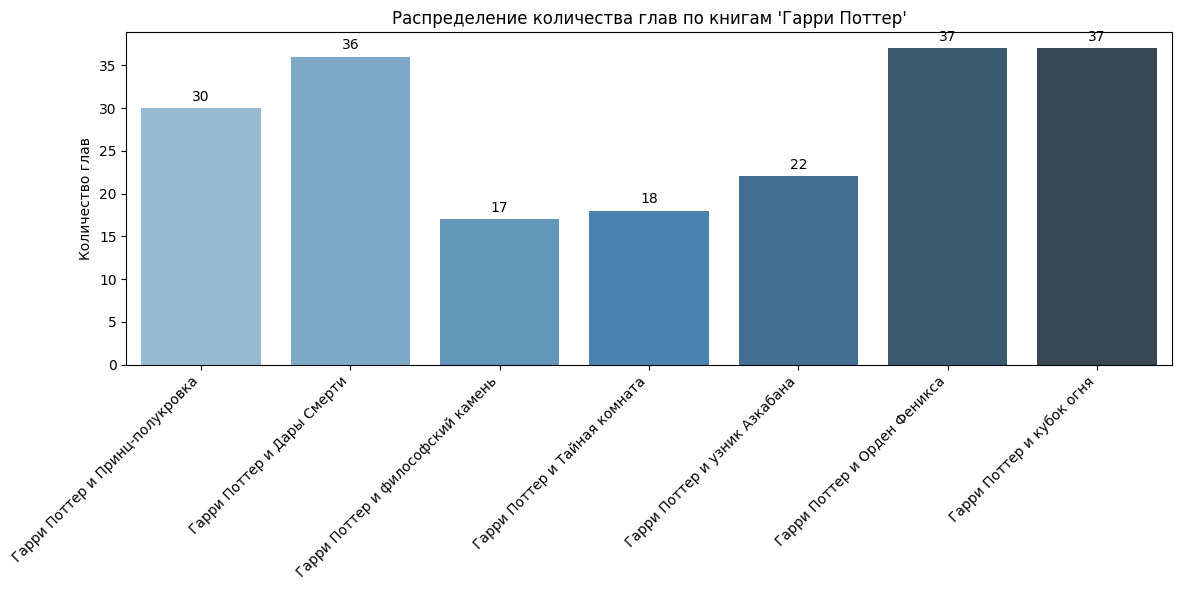

In [6]:
# Количество глав в каждой книге
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=books, y=chapters_per_book, palette="Blues_d")
plt.title("Распределение количества глав по книгам 'Гарри Поттер'")
plt.ylabel("Количество глав")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
for idx, val in enumerate(chapters_per_book):
    bars.text(idx, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('chapters_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

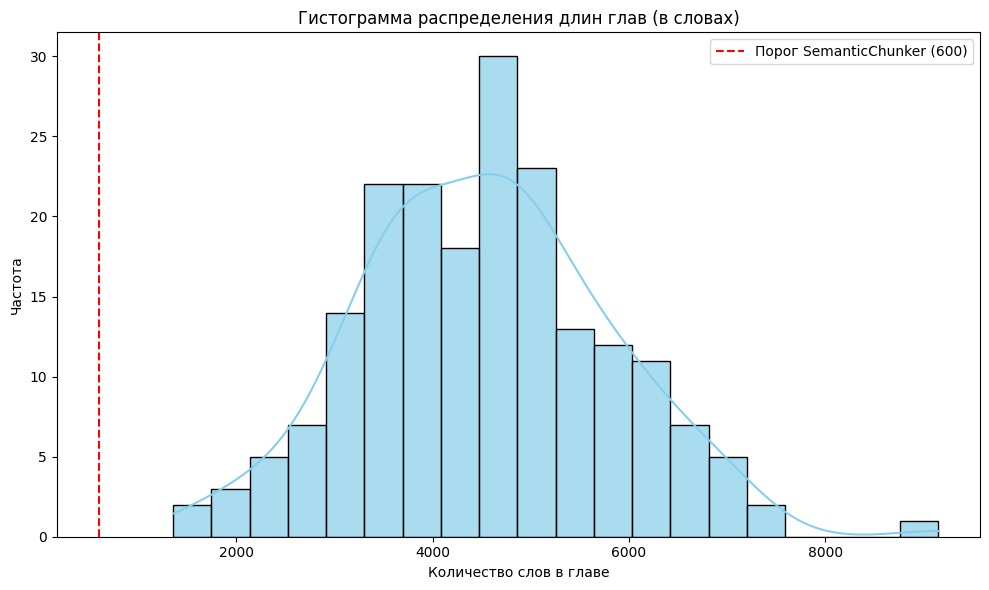

In [7]:
# Распределение длин глав
all_chapter_lengths = []
for chapters in all_books_data.values():
    all_chapter_lengths.extend([ch['word_count'] for ch in chapters])

plt.figure(figsize=(10, 6))
sns.histplot(all_chapter_lengths, bins=20, kde=True, color='skyblue', alpha=0.7)
plt.axvline(x=600, color='red', linestyle='--', label='Порог SemanticChunker (600)')
plt.title("Гистограмма распределения длин глав (в словах)")
plt.xlabel("Количество слов в главе")
plt.ylabel("Частота")
plt.legend()
plt.tight_layout()
plt.savefig('chapter_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# Вывод статистики
print(f"\n📊 Статистика по корпусу:")
print(f"Всего глав: {sum(chapters_per_book)}")
print(f"Средняя длина главы: {int(sum(all_chapter_lengths)/len(all_chapter_lengths))} слов")
print(f"Медианная длина главы: {int(sorted(all_chapter_lengths)[len(all_chapter_lengths)//2])} слов")
print(f"Самая длинная глава: {max(all_chapter_lengths)} слов")


📊 Статистика по корпусу:
Всего глав: 197
Средняя длина главы: 4537 слов
Медианная длина главы: 4583 слов
Самая длинная глава: 9151 слов


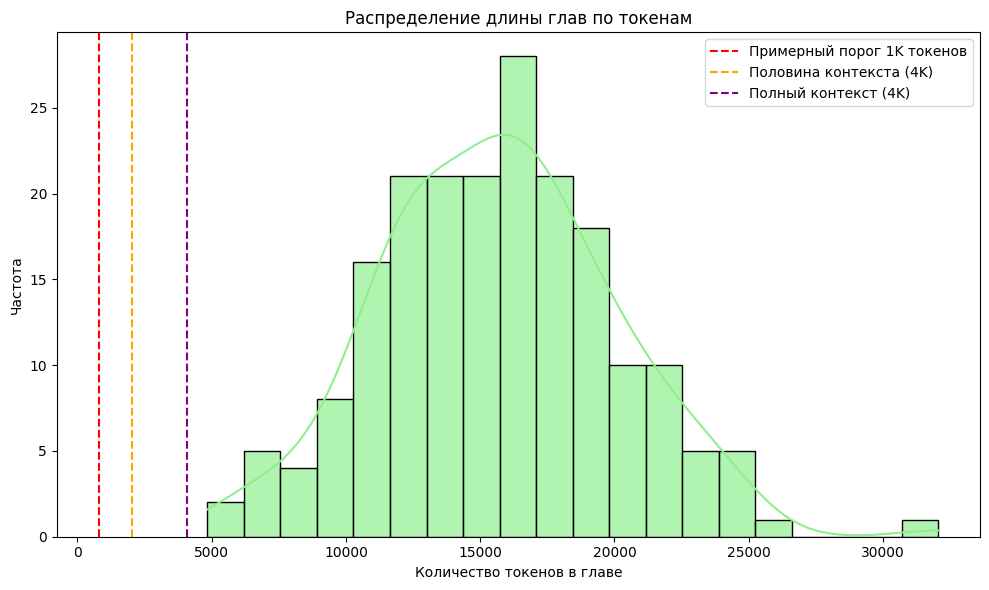

Статистика по токенам:
Всего токенов во всех книгах: 3,085,046
Средняя длина главы: 15660 токенов
Медианная длина главы: 15726 токенов
Самая длинная глава: 32049 токенов
Глав длиной > 4096 токенов (не поместятся в 4K-контекст): 197


In [9]:
# Подготовка данных по токенам
total_tokens_per_book = [sum(ch['token_count'] for ch in chapters) for chapters in all_books_data.values()]
all_chapter_tokens = []
for chapters in all_books_data.values():
    all_chapter_tokens.extend([ch['token_count'] for ch in chapters])

# Гистограмма распределения токенов в главах
plt.figure(figsize=(10, 6))
sns.histplot(all_chapter_tokens, bins=20, kde=True, color='lightgreen', alpha=0.7)
plt.axvline(x=800, color='red', linestyle='--', label='Примерный порог 1K токенов')
plt.axvline(x=2048, color='orange', linestyle='--', label='Половина контекста (4K)')
plt.axvline(x=4096, color='purple', linestyle='--', label='Полный контекст (4K)')
plt.title("Распределение длины глав по токенам")
plt.xlabel("Количество токенов в главе")
plt.ylabel("Частота")
plt.legend()
plt.tight_layout()
plt.savefig('chapter_token_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Статистика по токенам
print(f"Статистика по токенам:")
print(f"Всего токенов во всех книгах: {sum(all_chapter_tokens):,}")
print(f"Средняя длина главы: {int(sum(all_chapter_tokens)/len(all_chapter_tokens))} токенов")
print(f"Медианная длина главы: {int(sorted(all_chapter_tokens)[len(all_chapter_tokens)//2])} токенов")
print(f"Самая длинная глава: {max(all_chapter_tokens)} токенов")
print(f"Глав длиной > 4096 токенов (не поместятся в 4K-контекст): "
      f"{sum(1 for t in all_chapter_tokens if t > 4096)}")